In [1]:
# Imports + small setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    RocCurveDisplay
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Statistical Learning Methods (ID-based choice)

Run this notebook from the **base** conda environment:

```bash
conda activate base
jupyter lab
```

**Rule (last digit `n` of student login ID):**
- `n ∈ {0, 3, 6, 9}` → **Decision Tree**
- `n ∈ {1, 4, 7}` → **Linear Regression**
- `n ∈ {2, 5, 8}` → **Logistic Regression**

To make this notebook fully reproducible (and “big data” sized), we generate a large synthetic dataset in-memory and then train the model that matches your `n`.

In [2]:
# Load a classic classification dataset (Breast Cancer Wisconsin)
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')  # 0=malignant, 1=benign

print('X shape:', X.shape)
print('Class balance (target counts):')
print(y.value_counts())

X.head()

X shape: (569, 30)
Class balance (target counts):
target
1    357
0    212
Name: count, dtype: int64


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# Put your last digit here (or just type it when prompted)

# Option A: just hard-code it
last_digit = 6

# Option B: prompt (comment this in if you prefer)
# last_digit = int(input("Last digit of your student login ID (1-9): "))

if last_digit not in {1, 2, 3, 4, 5, 6, 7, 8, 9}:
    raise ValueError("last_digit must be 1..9")

use_naive_bayes = last_digit in {1, 3, 5, 7, 9}
use_knn = last_digit in {2, 4, 6, 8}

method = "Naïve Bayes" if use_naive_bayes else "k-NN"
print("last_digit:", last_digit)
print("method:", method)

last_digit: 6
method: k-NN


In [5]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

print('Train size:', X_train.shape)
print('Test size :', X_test.shape)

Train size: (426, 30)
Test size : (143, 30)


In [6]:
def evaluate_classifier(model, X_test, y_test, title='Model'):
    """Print a few standard metrics and plot confusion matrix + ROC curve."""
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f'{title} accuracy: {acc:.4f}')
    print('\nClassification report:')
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].imshow(cm, cmap='Blues')
    ax[0].set_title('Confusion matrix')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('True')

    for (i, j), v in np.ndenumerate(cm):
        ax[0].text(j, i, str(v), ha='center', va='center')

    # ROC-AUC (only if predict_proba exists)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        print(f'ROC-AUC: {auc:.4f}')
        RocCurveDisplay.from_predictions(y_test, y_proba, ax=ax[1])
        ax[1].set_title('ROC curve')
    else:
        ax[1].axis('off')
        print('ROC-AUC skipped (model has no predict_proba).')

    plt.tight_layout()
    plt.show()

    return acc

In [7]:
# Train the method that matches the rule

if use_naive_bayes:
    model = GaussianNB()
    model.fit(X_train, y_train)
    print("trained GaussianNB")

elif use_knn:
    k = 11
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    model.fit(X_train, y_train)
    print(f"trained k-NN with k={k}")

else:
    raise RuntimeError("digit-to-method mapping failed")

trained k-NN with k=11


k-NN accuracy: 0.9720

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        53
           1       0.96      1.00      0.98        90

    accuracy                           0.97       143
   macro avg       0.98      0.96      0.97       143
weighted avg       0.97      0.97      0.97       143

ROC-AUC: 0.9942


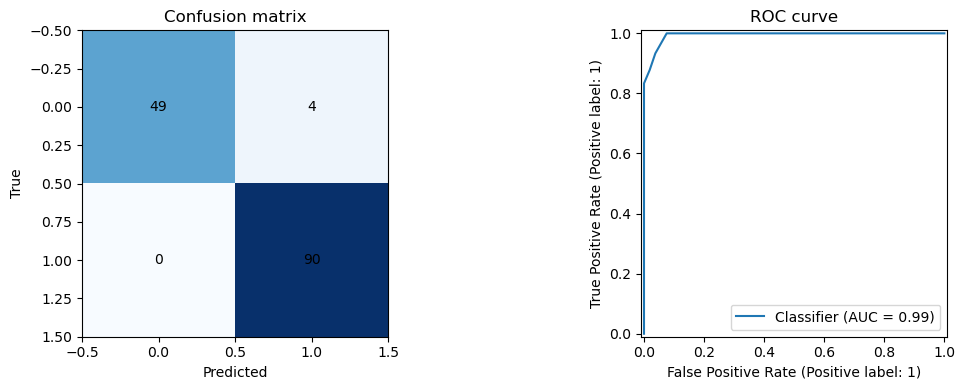

In [8]:
# Evaluate on held-out test set
_ = evaluate_classifier(
    model,
    X_test,
    y_test,
    title=('Naïve Bayes' if use_naive_bayes else 'k-NN')
)